# IFU Optimal Spectral Extraction

**Use case:** optimal spectral extraction; method by [Horne (1986)](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract).<br>
**Data:** JWST simulated NIRSpec IFU data; point sources.<br>
**Tools:**  jwst, webbpsf, matplotlib, scipy, custom functions.<br>
**Cross-intrument:** any spectrograph. <br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

## Imports 

* _time_ for adding a delay in Cubeviz file upload
* _numpy_ for array math
* _scipy_ for gaussian smoothing
* _specutils_ for Spectrum1D data model
* _jdaviz_ : Cubeviz data visualization tool
* _regions_ to read DS9 regions
* _photutils_ to define circular apertures
* _astropy.io_ for reading and writing FITS cubes and images
* _astropy.wcs, units, coordinates_ for defining and reading WCS
* _astropy.stats_ for sigma_clipping
* _astropy.utils_ for downloading files from URLs
* _matplotlib_ for plotting spectra and images

In [1]:
import time

import numpy as np

import scipy

import specutils
from specutils import Spectrum1D

from jdaviz import Cubeviz

from regions import CircleSkyRegion

from photutils import CircularAperture, SkyCircularAperture, aperture_photometry 

from astropy.io import fits
from astropy import wcs
import astropy.units as u
from astropy.stats import sigma_clip
from astropy.utils.data import download_file

/tmp/ipykernel_2837/1640329960.py:14: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, SkyCircularAperture, aperture_photometry
/tmp/ipykernel_2837/1640329960.py:14: DeprecationWarning: `photutils.SkyCircularAperture` is a deprecated alias for `photutils.aperture.SkyCircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import SkyCircularAperture` to silence this warning.
  from photutils import CircularAperture, SkyCircularAperture, aperture_photometry
/tmp/ipykernel_2837/1640329960.py:14: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Introduction

This notebook illustrates various extraction methods for a point source in JWST NIRSpec IFU data. First we
demonstrate a number of regular extraction techniques, including subset extraction with Cubeviz, simple sum over spaxels, cylindrical aperture, and conical aperture photometry. Then we compare optimal extraction using a WebbPSF model PSF to optimal extraction using a reference star PSF. 


## Read in Simulated NIRSpec IFU Cube

A faint (quasar) point source was simulated using the NIRSpec Instrument Performance Simulator (IPS), then run through the JWST Spec2 pipeline. We will use this for our science dataset.

We read in the data both with fits.open and Spectrum1D.read, since the cube handling (slicing) we need to do is not implemented in specutils yet.

In [3]:
# NIRSpec IFU science data cube
BoxPath = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_optimal_extraction/"
filename = BoxPath + "NRS00001-faintQSO-F100LP-G140H-01_1_491_SE_2020-08-25T12h15m00_s3d.fits"

# Open and inspect the file and WCS
# Load with astropy.fits.open
with fits.open(filename, memmap=False) as hdulist:
    sci = hdulist['SCI'].data
    err = hdulist['ERR'].data
    w = wcs.WCS(hdulist[1].header)
    hdr = hdulist[1].header
    hdulist.info()
    print(w)
    
# Load with Spectrum1D    
spec1d = Spectrum1D.read(filename)

# Wavelengths
wavelength = np.array(spec1d.spectral_axis.value)
print(wavelength)

# Sum over spaxels
fnu_sum = np.sum(spec1d.flux, axis=(0, 1))

# List of cube slices for aperture photometry
data = []
var = []
spec1d_len = len(spec1d.spectral_axis.value)
for idx in range(spec1d_len): 
    data.append(sci[idx, :, :])
    var.append(err[idx, :, :])  # variance = err, not variance = err**2.  Squaring the err gives noisy results. 

# Window data and variance (and replace NaNs)
# The existing JWST pipeline window is overgenerous (39x33 instead of the nominal 30x30 pixels)
data_win = np.nan_to_num(np.array(data)[:, 5:-4, 3:])
data_var = np.nan_to_num(np.array(var)[:, 5:-4, 3:]) 

Filename: /home/runner/.astropy/cache/download/url/edf217f740cafc32b47d3470859a08cd/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     295   ()      
  1  SCI           1 ImageHDU        64   (33, 39, 2059)   float32   
  2  ERR           1 ImageHDU        12   (33, 39, 2059)   float32   
  3  DQ            1 ImageHDU        12   (33, 39, 2059)   int32 (rescales to uint32)   
  4  WMAP          1 ImageHDU        10   (33, 39, 2059)   float32   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [10315B]   
WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'WAVE'  
CRVAL : 156.1778928912249  -45.68697658856264  9.665214562483711e-07  
CRPIX : 17.0  20.0  1.0  
PC1_1 PC1_2 PC1_3  : -0.8098302221786426  -0.586664308822422  0.0  
PC2_1 PC2_2 PC2_3  : -0.586664308822422  0.8098302221786426  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 2.77777781916989e-05  2.77777781916989e-05  2.3499999952036797e-10  
NAXIS : 

*Developer Note:* Can we fix or suppress this AsdfWarning?

*Developer Note:*  Is there a way to read in with only Spectrum1D to perform all of our cube operations, not using fits.open()?

## Visualize Science Data with Cubeviz

*Developer Note:* Cubeviz incompatible with jupyter_client 6.1.6.  Use jupyter_client 5.3.5 instead.

In [4]:
cubeviz = Cubeviz()
cubeviz.app

/opt/hostedtoolcache/Python/3.11.4/x64/lib/python3.11/site-packages/glue/viewers/common/qt/__init__.py:3: GlueDeprecationWarning: Importing from glue.viewers.common.qt is deprecated, use glue_qt.viewers.common instead
  warnings.warn('Importing from glue.viewers.common.qt is deprecated, use glue_qt.viewers.common instead', GlueDeprecationWarning)


Application(config='cubeviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

### UI Instructions:
* Load science datacube into Cubeviz using the next code cell below
* Go to the Hammer-and-Screwdriver icon: Gear icon: Layer in the leftmost image viewer 
* In that tab, change the Linear stretch to 90 percentile to see the faint QSO target at (x,y) ~ (17, 21)
* Scrubbing through the cube also helps to locate the source
* Select a circular subset region centered on the source. 
* Note that the region is pixelated and doesn't include fractional pixels
* Change the collapse method to "Sum" in spectrum viewer: Gear icon : Viewer 
* --This "Sum" method yields our subset extraction
* Change the vertical zoom to see the spectral features in the Subset spectrum

*Developer Notes*: 

(1) Image viewer contrast settings change when you click on the side bar to expand/contract jupyter scroll window

(2) Spectrum viewer: Viewer cube collapse method should default to Sum (not Maximum)

(3) Spectrum viewer y scale returns to autoscale when the region is moved, and y-zoom has to be adjusted again

(4) Region selection appears away from cursor after opening hammer-and-screwdriver to change cube viewer contrast

## Load Cube into Cubeviz

In [5]:
# Data from local directory
# cubeviz.app.load_data(filename)

# Data from url:
url = filename
df = download_file(url)
time.sleep(2)  # Sleep to avoid glue-jupyter timing issue
cubeviz.app.load_data(df)

*Developer Note:* Spectral cube does not yet recognize JWST NIRSpec IFU datacubes, giving the above warning
for each FITS extension.

## Export Region from Cubeviz
Export the region defined by the user in Cubeviz as an astropy CirclePixel Region, which has units of pixels.

*Developer Note:* cubeviz.app.get_subsets_from_viewer method doesn't work if there are more than 2 datasets selected in the spectrum viewer:

#region1 = cubeviz.app.get_subsets_from_viewer('spectrum-viewer')

#print(region1['Subset1'])


In [6]:
cubeviz_data = cubeviz.app.data_collection[0]
try:
    region1 = cubeviz_data.get_selection_definition(format='astropy-regions')
    print(region1)
    region1_exists = True
except Exception:
    print("There are no regions selected in the cube viewer.")
    region1_exists = False

There are no regions selected in the cube viewer.


## Extract Subset Spectrum in Cubeviz Spectrum Viewer
Retrieve the collapsed spectrum (Subset1) of the user-defined region from the Spectrum Viewer as a Spectrum1D object.

In [7]:
try:
    spectrum_subset1 = cubeviz.app.get_data_from_viewer('spectrum-viewer')['Subset 1']
    print(spectrum_subset1)
except Exception:
    print("There are no subsets selected in the spectrum viewer.")

        Use viz_helper.get_data instead. [warnings]
2023-08-21 13:14:10,119 - stpipe - WARNING - AstropyDeprecationWarning: The get_data_from_viewer function is deprecated and may be removed in a future version.
        Use viz_helper.get_data instead.


There are no subsets selected in the spectrum viewer.


*Developer Note:* Can we suppress or fix this glue/core warning?

## Extract Spectrum by Sum Over Spaxels

Perform a simple numpy sum over all spaxels in the cube as a rudimentary extraction method. Also sum over wavelength to collapse the cube.

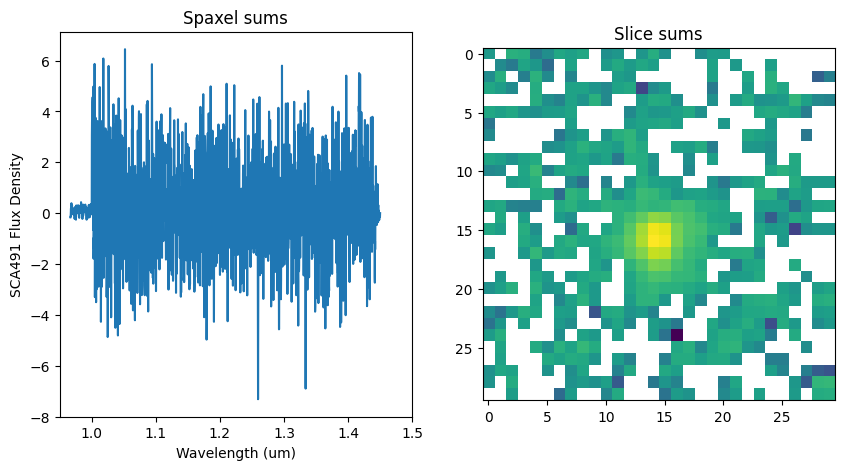

In [8]:
# Sum over wavelength
cube_sum = np.sum(data_win, axis=0)

# Plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 
ax1.plot(wavelength, fnu_sum) 
ax1.set_xlim(0.95, 1.5)
ax1.set_title("Spaxel sums")
ax1.set_xlabel("Wavelength (um)")  
ax1.set_ylabel("SCA491 Flux Density")

ax2.imshow(cube_sum, norm=LogNorm())
ax2.set_title("Slice sums")

plt.show()

## Extract Spectrum in Constant Radius Circular Aperture (Cylinder)
This method is appropriate for an extended source.

In [9]:
# IFU pixel scale
pixelscale = 0.1  # arcsec/pixel

# CircularAperture uses xy pixels
center_xy = [17.1, 20.]
r_pix = 5.92
if region1_exists:
    center_xy = [region1.center.x, region1.center.y]   
    r_pix = region1.radius

aperture = CircularAperture(center_xy, r=r_pix)
print(aperture)

cylinder_sum = []
for slice2d in data:
    phot_table = aperture_photometry(slice2d, aperture, wcs=w.celestial, method='exact')
    phot_table = aperture_photometry(slice2d, aperture)
    cylinder_sum.append(phot_table['aperture_sum'][0])

Aperture: CircularAperture
positions: [17.1, 20. ]
r: 5.92


*Developer Note:*  Is there a way to retrieve the coordinates (RA, Dec) of the Subset1 region, for use in a SkyCircularAperture?

## Extract Spectrum in Linearly Expanding Circular Aperture (Cone)
This method is appropriate for a point source PSF with width proportional to wavelength

In [10]:
# Reference wavelength for expanding aperture
lambda0 = wavelength[0]
print('Reference wavelength:', lambda0)

cone_sum = []
idx = -1
for (slice2d, wave) in zip(data, wavelength):
    idx = idx + 1
    r_cone = r_pix * wave / lambda0
    aperture_cone = CircularAperture(center_xy, r=r_cone)
    phot_table = aperture_photometry(slice2d, aperture_cone, wcs=w.celestial, method='exact')
    cone_sum.append(phot_table['aperture_sum'][0])

Reference wavelength: 0.9665214562483713


## Plot and Compare Non-optimal Spectral Extractions
Compare spectra extracted in cylinder, cone, Cubeviz subset.

There is no Cubeviz Subset1 spectrum to plot.


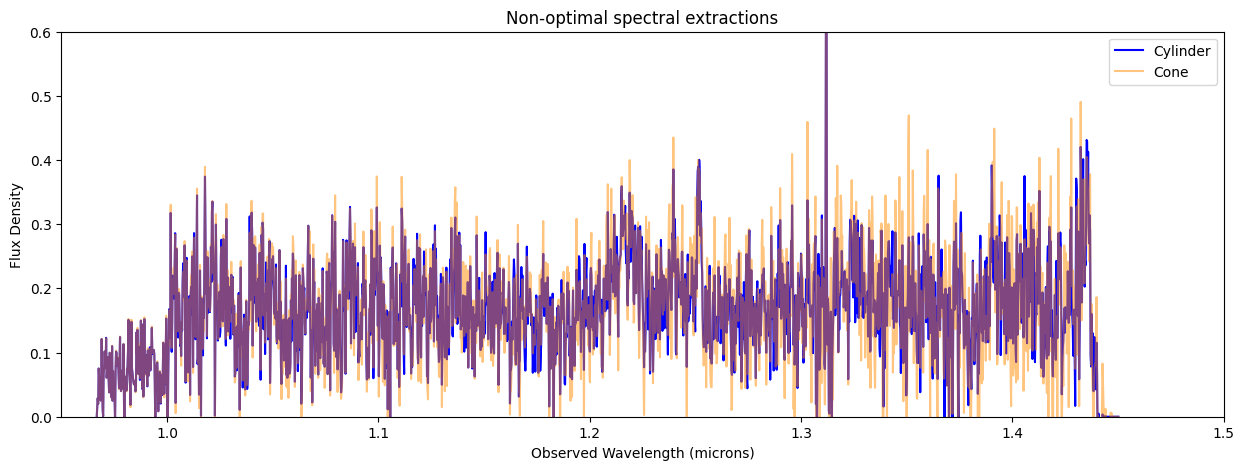

In [11]:
f, (ax1) = plt.subplots(1, 1, figsize=(15, 5)) 

ax1.set_title("Non-optimal spectral extractions")
ax1.set_xlabel("Observed Wavelength (microns)")  
ax1.set_ylabel("Flux Density")
ax1.set_xlim(0.95, 1.5)
ax1.set_ylim(0, 0.6)
ax1.plot(wavelength, np.array(cylinder_sum), label="Cylinder", c='b')
ax1.plot(wavelength, np.array(cone_sum), label="Cone", c='darkorange', alpha=0.5)
try:
    ax1.plot(wavelength, spectrum_subset1.flux.value, c='r', label="Subset1", alpha=0.4)
except Exception:
    print("There is no Cubeviz Subset1 spectrum to plot.")
ax1.legend()

plt.show()

Comparison of the (non-optimal) cylindrical, conical, and Cubeviz subset spectral extractions. 
The conical extraction captures slightly more flux but is noisier than the other spectra at long wavelengths.
Red-shifted Broad H-beta and narrow [O III] lines  are visible in the quasar spectra. 

## WebbPSF  Model PSF for Optimal Extraction
Generate PSF model cube using WebbPSF for NIRSpec IFU, or read in precomputed PSF model cube.

Caution! The WebbPSF model takes about 10 hr to run.  Uncomment the following cell to do so. Otherwise, read in the precomputed WebbPSF model, which covers the full F100LP/G140H wavelength range (blue and red). For other filter/grating combinations, uncomment and run the cell below using the wavelengths from the science data set.

In [12]:
'''
#WebbPSF imports
%pylab inline
import webbpsf

#WebbPSF commands used to create PSF model cube
ns.image_mask = "IFU"  # Sets to 3x3 arcsec square mask
ns = webbpsf.NIRSpec()
wavelengths = wavelength*1.0E-6
psfcube = ns.calc_datacube(wavelengths, fov_pixels=30, oversample=4,  add_distortion=True)
psfcube.writeto("Webbpsf_ifucube.fits")
'''

'\n#WebbPSF imports\n%pylab inline\nimport webbpsf\n\n#WebbPSF commands used to create PSF model cube\nns.image_mask = "IFU"  # Sets to 3x3 arcsec square mask\nns = webbpsf.NIRSpec()\nwavelengths = wavelength*1.0E-6\npsfcube = ns.calc_datacube(wavelengths, fov_pixels=30, oversample=4,  add_distortion=True)\npsfcube.writeto("Webbpsf_ifucube.fits")\n'

In [13]:
BoxPath = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_optimal_extraction/"
psf_filename = BoxPath+"Webbpsf_ifucube.fits"

# Load with astropy.fits.open
with fits.open(psf_filename, memmap=False) as hdulist:
    psf_model = hdulist['DET_SAMP'].data
    psf_hdr = hdulist['DET_SAMP'].header
    hdulist.info()    
print(psf_model.shape)

# Sum over wavelength
psf_model_sum = np.sum(psf_model, axis=0)

# Sum over spaxels
psf_model_fnusum = np.sum(psf_model, axis=(1, 2))

Filename: /home/runner/.astropy/cache/download/url/4931b72fec159f8a439e8c80c181370f/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU   105786   (120, 120, 3915)   float64   
  1  DET_SAMP      1 ImageHDU     105788   (30, 30, 3915)   float64   
  2  OVERDIST      1 ImageHDU     105831   (120, 120, 3915)   float64   
  3  DET_DIST      1 ImageHDU     105832   (30, 30, 3915)   float64   
(3915, 30, 30)


*Developer Note:*  The file Webbpsf_ifucube.fits is large (946.3 MB) and takes some time to load from Box.
It might behoove the user to download it to a local directory and retrieve it from there.

## Align Model PSF Cube with Science Data
Flip, smooth, and shift the model PSF cube to align with the simulated data. Trim the simulated data. 

*Developer Note:*  Automate this by finding the (x,y) offset between the Model and simulated PSF peaks.  Currently the shift is determined empirically by eye.

/tmp/ipykernel_2837/206052846.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  psf_model_smoothed = scipy.ndimage.filters.gaussian_filter(psf_model_fliplr,


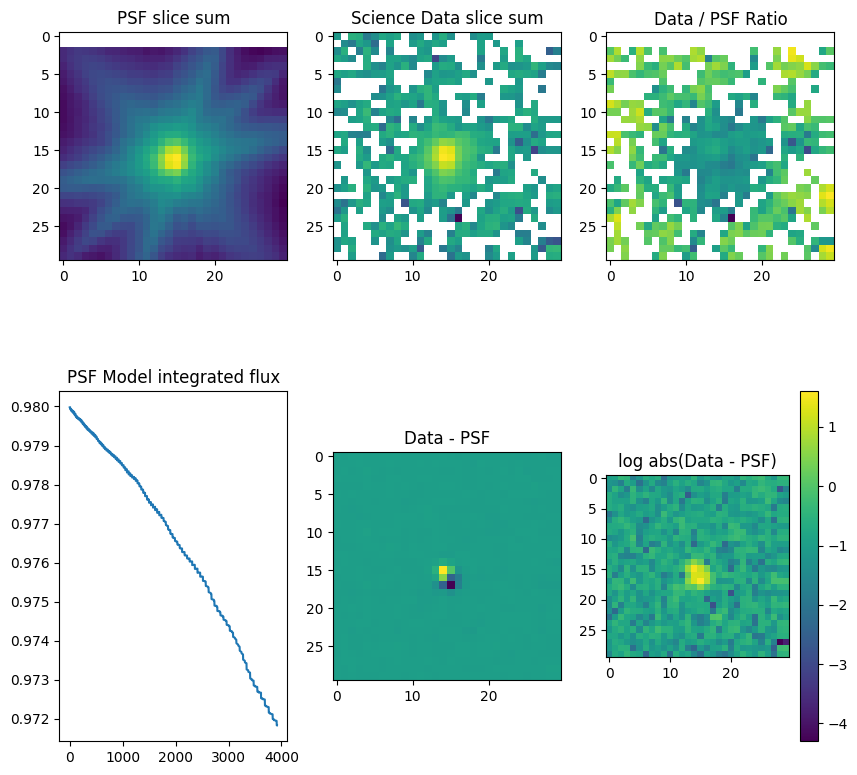

In [14]:
# Flip model PSF left-right.  For some unknown reason, WebbPSF is flipped with respect to the IPS simulation.
psf_model_fliplr = psf_model[:, ::-1, :]

# Smooth model
# EMSM smoothing for G140H grating
scalerad = 0.046  # sigma (arcsec)
pixelscale = 0.1
scalerad_pix = scalerad / pixelscale
psf_model_smoothed = scipy.ndimage.filters.gaussian_filter(psf_model_fliplr, 
                                                           (0.0, scalerad_pix, scalerad_pix), 
                                                           order=0, mode='reflect', cval=0.0,  
                                                           truncate=10.0)

# Empirically (chi-by-eye) determined shift
shiftx = 1.75    
shifty = 0.

# Shift model PSF using linear interpolation
psf_model_aligned = scipy.ndimage.shift(psf_model_smoothed, (0.0, shiftx, shifty), order=1, 
                                        mode='constant', cval=0.0, prefilter=True)

# Sum over wavelength
psf_model_sum = np.sum(psf_model_aligned, axis=0)

# Scale factor for PSF subtraction
psf_sum_min = np.amin(psf_model_sum)
psf_sum_max = np.amax(psf_model_sum)
scalefactor = np.amax(cube_sum) / psf_sum_max

# Plots
f, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(10, 10)) 

ax1.set_title("PSF slice sum")
ax1.imshow(psf_model_sum, norm=LogNorm())

ax2.set_title("Science Data slice sum")
ax2.imshow(cube_sum, norm=LogNorm()) 

ax3.set_title("Data / PSF Ratio")
ax3.imshow(cube_sum / psf_model_sum, norm=LogNorm())

ax4.set_title("PSF Model integrated flux")
ax4.plot(psf_model_fnusum)

ax5.set_title("Data - PSF")
ax5.imshow(cube_sum - scalefactor * psf_model_sum)

im6 = ax6.imshow(np.log10(np.absolute(cube_sum - scalefactor * psf_model_sum)))
plt.colorbar(im6)
ax6.set_title("log abs(Data - PSF)")

plt.show()

_Figure top row_: Comparison of smoothed, aligned WebbPSF PSF (left) to IPS simulation (center). 

_Figure bottom row_: Integrated WebbPSF model flux (left) decreases with wavelength as PSF expands outside of the FOV. 
Differences (center, right) between the model PSF and IPS-simulated PSF will translate to inaccuracy in the optimally-extracted spectrum.

## Optimal Extraction using WebbPSF Model
Optimal extraction (Horne 1986, PASP, 98, 609) weights the flux contributions to a spectrum by their signal-to-noise ratio (SNR). Dividing the simulated data by the model PSF gives an estimate of the total flux density spectrum in each spaxel. A weighted average of these estimates over all spaxels yields the optimally extracted spectrum over the cube. In the faint source limit, where the noise is background-dominated, optimal extraction inside a 3-sigma radius can increase the effective exposure time by a factor of 1.69 (Horne et al. 1986). In the bright source limit, where the noise is dominated by the Poisson statistics of the source, optimal extraction is formally identical to a straight sum over spaxels for a perfect PSF model. 

We use the WebbPSF PSF model for this first attempt at optimal extraction.

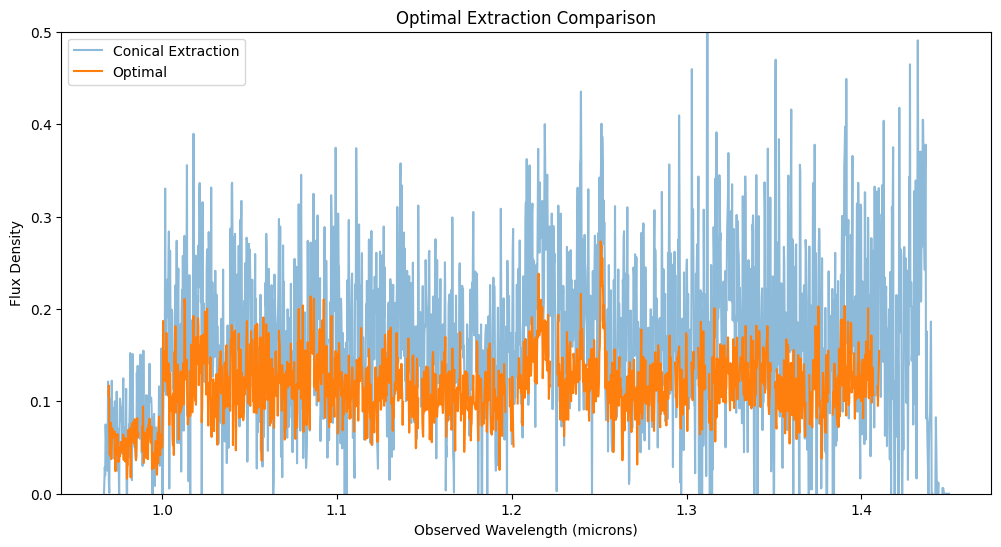

In [15]:
# Window PSF model (and replace NaNs)
profile = np.nan_to_num(psf_model_aligned[0:2059, :, :]) 

# Divide data by PSF model
data_norm = np.nan_to_num(data_win / profile)
data_norm_sum = np.sum(data_norm, axis=0) 

# Mask out bad data using 3-sigma clipping in each slice
data_norm_clipped = sigma_clip(data_norm, sigma=3.0, maxiters=5, axis=(1, 2))
data_norm_clipped_sum = np.sum(data_norm_clipped, axis=0)   
badvoxel = np.where(data_norm_clipped == 0)
data_clean = 1.0 * data_win
data_clean[badvoxel] = 0.0

# Optimal extraction, using model profile weight and variance cube from the simulated data
optimal_weight = profile ** 2 / data_var
optimal_weight_norm = np.sum(optimal_weight, axis=(1, 2))
spectrum_optimal = np.sum(profile * data_clean / data_var, axis=(1, 2)) / optimal_weight_norm

opt_scalefactor = np.median(np.nan_to_num(cone_sum / spectrum_optimal))  # = 1.33, not ~1.0 because PSF model isn't perfect

# Plots
f, (ax1) = plt.subplots(1, 1, figsize=(12, 6)) 
ax1.set_title("Optimal Extraction Comparison")
ax1.set_xlabel("Observed Wavelength (microns)") 
ax1.set_ylabel("Flux Density")
ax1.set_ylim(0, 0.5)
ax1.plot(wavelength, cone_sum, label="Conical Extraction", alpha=0.5)
ax1.plot(wavelength, spectrum_optimal, label="Optimal")
ax1.legend()

plt.show()

The optimally extracted spectrum is less noisy than the aperture extraction, but the flux density is low by a factor of ~1.33 because the PSF model doesn't match the science data perfectly.

## Optimal Extraction with (Simulated) Reference Star PSF
A real (or simulated in this case) IFU observation of a star may be used for the PSF model rather than WebbPSF.  We employ a NIRSpec IPS simulated PSF, which matches our data better than the WebbPSF model.  We don't have to shift or smooth the PSF model because it was simulated at the same dither/detector position as the data. When using a real observation of a star for the PSF model, make sure it was observed at the same dither positions. It is also beneficial to reduce and extract both simulated datasets in the 'ifualign' detector coordinate system, so that we don't have to rotate the PSF star to match the science data.

Filename: /home/runner/.astropy/cache/download/url/aaf16a39c40575c919f074757ea17caa/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     295   ()      
  1  SCI           1 ImageHDU        64   (33, 39, 2059)   float32   
  2  ERR           1 ImageHDU        12   (33, 39, 2059)   float32   
  3  DQ            1 ImageHDU        12   (33, 39, 2059)   int32 (rescales to uint32)   
  4  WMAP          1 ImageHDU        10   (33, 39, 2059)   float32   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [10314B]   
WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'WAVE'  
CRVAL : 156.1778928912249  -45.68697658856264  9.665214562483711e-07  
CRPIX : 17.0  20.0  1.0  
PC1_1 PC1_2 PC1_3  : -0.8098302221786426  -0.586664308822422  0.0  
PC2_1 PC2_2 PC2_3  : -0.586664308822422  0.8098302221786426  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 2.77777781916989e-05  2.77777781916989e-05  2.3499999952036797e-10  
NAXIS : 

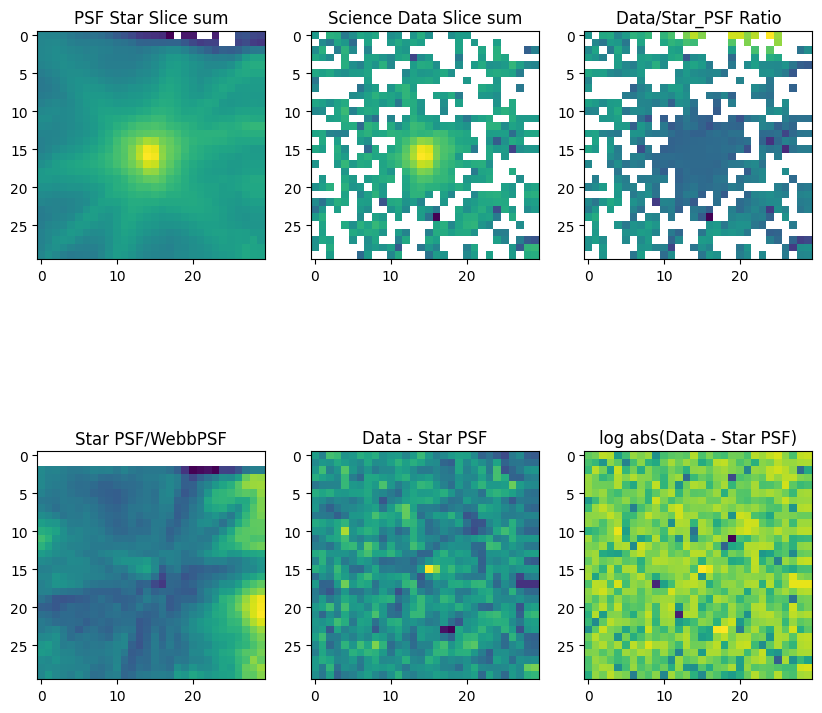

In [16]:
BoxPath = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_optimal_extraction/"
filename_star = BoxPath + "NRS00001-brightQSO-F100LP-G140H-01_1_491_SE_2020-08-26T12h15m00_s3d.fits"

# Open and inspect the file and WCS
with fits.open(filename_star, memmap=False) as hdulist:
    sci_star = hdulist['SCI'].data
    err_star = hdulist['ERR'].data
    w_star = wcs.WCS(hdulist[1].header)
    hdr_star = hdulist[1].header
    hdulist.info()
    print(w_star)
    
# Load with Spectrum1D    
spec1d_star = Spectrum1D.read(filename_star)

# Wavelengths
wavelength_star = np.array(spec1d_star.spectral_axis.value)

# Window reference star to match science data (and replace NaNs)
ref_star = np.nan_to_num(sci_star[:, 5:-4, 3:])

# Sum over spaxels
ref_star_fnusum = np.sum(ref_star, axis=(1, 2))

# Normalize PSF star profile to unity. (The flux will still be slightly off. Please see Developer's Note below.)
ref_star_norm = []
for idx, norm in zip(range(len(wavelength_star)), ref_star_fnusum):
    ref_star_norm.append(ref_star[idx] / norm)
profile_star = np.array(ref_star_norm)
    
# Sum over spaxels 
profile_star_fnusum = np.sum(profile_star, axis=(1, 2))

# Sum over wavelength
profile_star_sum = np.sum(profile_star, axis=0)

# Scale factor for PSF subtraction
profile_star_sum_max = np.amax(profile_star_sum)
star_scalefactor = np.amax(cube_sum) / profile_star_sum_max

# Make slight adjustment to scale factor
star_scalefactor = 0.175

# Plots
f, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(10, 10)) 

ax1.imshow(profile_star_sum, norm=LogNorm())
ax1.set_title("PSF Star Slice sum")

ax2.imshow(cube_sum, norm=LogNorm()) 
ax2.set_title("Science Data Slice sum")

ax3.imshow(cube_sum / profile_star_sum, norm=LogNorm())
ax3.set_title("Data/Star_PSF Ratio")

star_model_ratio = profile_star_sum / psf_model_sum
ax4.imshow(star_model_ratio, norm=LogNorm())
ax4.set_title("Star PSF/WebbPSF")

ax5.imshow(cube_sum - star_scalefactor * profile_star_sum)
ax5.set_title("Data - Star PSF")

ax6.imshow(np.log10(np.absolute(cube_sum - star_scalefactor * profile_star_sum)))
ax6.set_title("log abs(Data - Star PSF)")

plt.show()

_Figure top row_: Comparison of PSF star and science data. Bottom left: ratio of PSF star to WebbPSF model shows 
significant differences that can affect the quality of the optimal extraction.  Bottom right:
Difference of PSF star from science data shows they are well matched, with a scale factor of 0.175. 

*Developer Note:* It would be good to renormalize the PSF profile to account for the fraction of flux lost outside of the detector. Otherwise the extracted flux will be low by a factor of roughly 0.972 to 0.980.

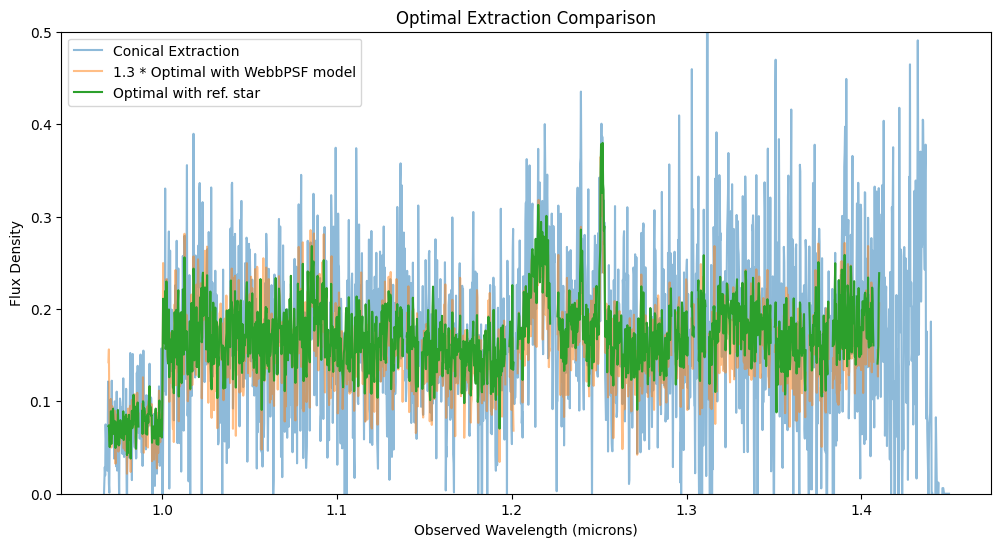

In [17]:
# Mask out bad data using 3-sigma clipping in each slice
data_norm = np.nan_to_num(data_win / profile_star)
data_norm_clipped = sigma_clip(data_norm, sigma=3.0, maxiters=5, axis=(1, 2))
data_norm_clipped_sum = np.sum(data_norm_clipped, axis=0)   
badvoxel = np.where(data_norm_clipped == 0)[0]
data_clean = 1.0 * data_win
data_clean[badvoxel] = 0.0

# Optimal extraction, using model profile weight and variance cube from the simulated data
optimal_weight = profile_star**2 / data_var
optimal_weight_norm = np.sum(optimal_weight, axis=(1, 2))
spectrum_optimal_star = np.sum(profile_star * data_clean / data_var, axis=(1, 2)) / optimal_weight_norm

# Plots
f, (ax1) = plt.subplots(1, 1, figsize=(12, 6)) 
ax1.set_title("Optimal Extraction Comparison")
ax1.set_xlabel("Observed Wavelength (microns)") 
ax1.set_ylabel("Flux Density")
ax1.set_ylim(0, 0.5)

ax1.plot(wavelength, cone_sum, label="Conical Extraction", alpha=0.5)
ax1.plot(wavelength, spectrum_optimal * opt_scalefactor, label="1.3 * Optimal with WebbPSF model", alpha=0.5)
ax1.plot(wavelength, spectrum_optimal_star, label="Optimal with ref. star")
ax1.legend()

plt.show()

The optimal extraction with the perfectly matched PSF star is less noisy than that achieved with WebbPSF, and unlike the latter, doesn't need to be rescaled.  The scaling can be off if the PSF of the reference star is not a good match to the PSF of the science data.

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

Notebook created by Patrick Ogle and James Davies.